# Imports

In [1]:
import sys
sys.path.append('/home/student/project/HumanChoicePrediction/')

In [2]:
import pandas as pd
from consts import N_HOTELS
import glob
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank
import numpy as np
nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')
nltk.download('punkt')

pd.options.mode.chained_assignment = None

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Functions

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

In [4]:
def get_sentiment_scores_vectorized(reviews):
    analyzer = SentimentIntensityAnalyzer()
    # Apply the sentiment analysis to each review
    scores = [analyzer.polarity_scores(review) for review in reviews]
    # Extract positive and negative scores
    positive_scores = [score['pos'] for score in scores]
    negative_scores = [score['neg'] for score in scores]
    return pd.DataFrame({'concat_positive_score': positive_scores, 'concat_negative_score': negative_scores})

def get_positive_negative_neutral_counts(sentence):

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    neu_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            pos_words += 1
        elif word in opinion_lexicon.negative():
            neg_words += 1
        else:
            neu_words +=1

    return pos_words, neg_words, neu_words
        

# Import Trip Advisor hotel reviews

In [5]:
df_training = pd.read_csv('/home/student/project/HumanChoicePrediction/data/tripadvisor_hotel_reviews.csv')
# get scores out of 10 instead of 5
df_training['Rating'] = df_training['Rating'] * 2
df_training

,Review,Rating
0,nice hotel expensive parking got good deal sta...,8
1,ok nothing special charge diamond member hilto...,4
2,nice rooms not 4* experience hotel monaco seat...,6
3,"unique, great stay, wonderful time hotel monac...",10
4,"great stay great stay, went seahawk game aweso...",10
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",10
20487,great location price view hotel great quick pl...,8
20488,"ok just looks nice modern outside, desk staff ...",4
20489,hotel theft ruined vacation hotel opened sept ...,2


## Calculate sentiment scores for each review

In [6]:
results_df = get_sentiment_scores_vectorized(df_training['Review'])

Define good review, good to bad ratio and handle infinite results

In [7]:
df_training[['positive_score', 'negative_score']] = results_df
df_training['positive_to_negative_sentiment_ratio']= df_training['positive_score']/df_training['negative_score']
df_training['is_good_review'] = (df_training['Rating']>=8).astype(int)
df_training['positive_to_negative_sentiment_ratio'] = df_training['positive_to_negative_sentiment_ratio'].replace([np.inf], 100)
df_training = df_training.dropna()
df_training

,Review,Rating,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review
0,nice hotel expensive parking got good deal sta...,8,0.285,0.072,3.958333,1
1,ok nothing special charge diamond member hilto...,4,0.189,0.110,1.718182,0
2,nice rooms not 4* experience hotel monaco seat...,6,0.219,0.081,2.703704,0
3,"unique, great stay, wonderful time hotel monac...",10,0.385,0.060,6.416667,1
4,"great stay great stay, went seahawk game aweso...",10,0.221,0.135,1.637037,1
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",10,0.272,0.063,4.317460,1
20487,great location price view hotel great quick pl...,8,0.430,0.000,100.000000,1
20488,"ok just looks nice modern outside, desk staff ...",4,0.145,0.131,1.106870,0
20489,hotel theft ruined vacation hotel opened sept ...,2,0.179,0.150,1.193333,0


<Axes: >

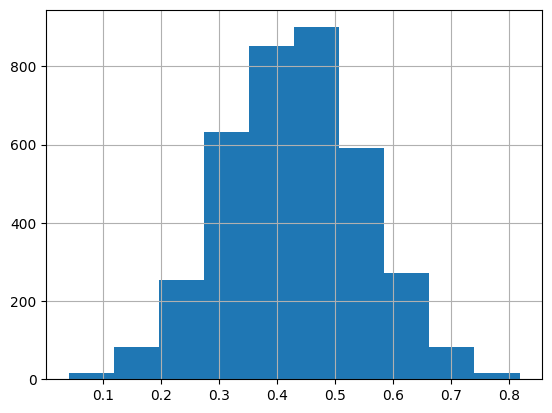

In [8]:
df_training.loc[df_training['positive_to_negative_sentiment_ratio']==100.0, 'positive_score'].hist()

In [9]:
X, y = df_training.drop(['is_good_review'],axis=1), df_training['is_good_review']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


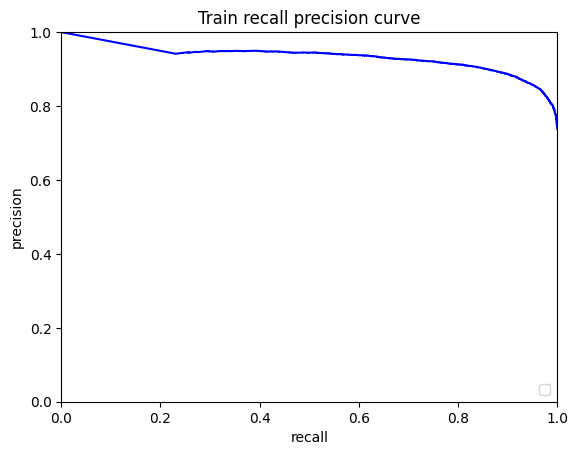

In [11]:
from sklearn.metrics import precision_recall_curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, X_train['positive_to_negative_sentiment_ratio'])

import matplotlib.pyplot as plt
plt.title('Train recall precision curve')
plt.plot( recall_train, precision_train, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [12]:
opt_idx, recall_value = find_nearest(recall_train, 0.85)
opt_idx, recall_value, thresholds_train[opt_idx]

(3667, 0.8499654525713157, 2.8469387755102042)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


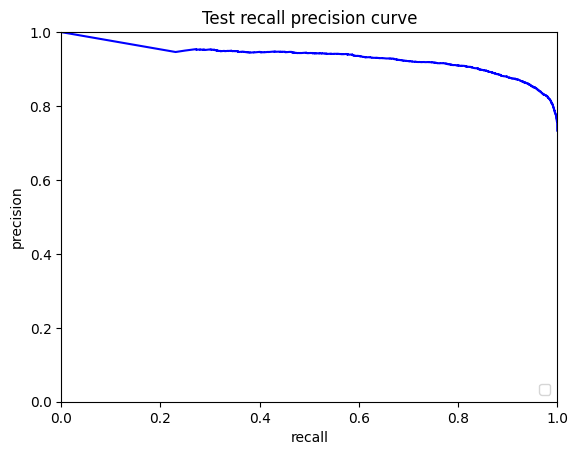

In [13]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, X_test['positive_to_negative_sentiment_ratio'])
# roc_auc = metrics.auc(precision, recall)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Test recall precision curve')
plt.plot( recall_test, precision_test, 'b',)# label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [14]:
idx_th, th_value = find_nearest(thresholds_test, 2.8469387755102042)
idx_th, th_value, recall_test[idx_th], precision_test[idx_th]

(1924, 2.8461538461538463, 0.8497680984069369, 0.8973594548551959)

In [15]:
optimal_ratio = 2.8469387755102042
positive_to_negative_sentiment_ratio_threshold = optimal_ratio

# Load Booking reviews

In [16]:
file_paths = glob.glob('/home/student/project/HumanChoicePrediction/data/game_reviews/*.csv')
file_paths

['/home/student/project/HumanChoicePrediction/data/game_reviews/991.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/340.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/1013.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/521.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/438.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/480.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/28.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/1057.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/594.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/741.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/857.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/315.csv',
 '/home/student/project/HumanChoicePrediction/data/game_reviews/570.csv',
 '/home/student/project/HumanChoicePr

In [17]:
sia = SentimentIntensityAnalyzer()

data_frames = []

for file_path in file_paths:
    df = pd.read_csv(file_path, header=None)
    
    # Extract the required columns: 0 (ID), 2 (positive_review), 3 (negative_review)
    selected_columns = df[[0, 2, 3, 4]]
    
    selected_columns.columns = ['ID', 'positive_review', 'negative_review','rating']
       
    # Concatenate positive and negative reviews
    
    # Calculate sentiment scores for the concatenated review
    
    # Append the DataFrame to the list
    data_frames.append(selected_columns)


# Concatenate all the DataFrames in the list into a single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)

combined_df['concat_review'] = combined_df['positive_review'].astype(str) + ". " + combined_df['negative_review'].astype(str)

results_df = get_sentiment_scores_vectorized(combined_df['concat_review'].astype(str))

combined_df[['positive_score', 'negative_score']] = results_df

# combined_df[['positive_word_count','negative_word_count','neutral_word_count']] = combined_df['concat_review'].apply(lambda x: pd.Series(get_positive_negative_neutral_counts(str(x))))

combined_df.head()

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000


In [18]:
combined_df['positive_to_negative_sentiment_ratio']= combined_df['positive_score']/combined_df['negative_score']
combined_df['is_good_review'] = (combined_df['rating']>=8).astype(int)
combined_df['positive_to_negative_sentiment_ratio'] = combined_df['positive_to_negative_sentiment_ratio'].replace([np.inf], 100)
combined_df['positive_to_negative_sentiment_ratio'] = combined_df['positive_to_negative_sentiment_ratio'].replace([np.nan], 0)

combined_df

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000,100.000000,0
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000,100.000000,1
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242,0.000000,0
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116,3.060345,1
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000,100.000000,1
...,...,...,...,...,...,...,...,...,...
7471,23647,"Location, room size, parking, staff",Noise from the highway with windows open.,9.0,"Location, room size, parking, staff. Noise fro...",0.000,0.000,0.000000,1
7472,23652,The Locations is good.\nGood breakfast in COVI...,Very small room for a twin bed room.\nPoor ref...,6.0,The Locations is good.\nGood breakfast in COVI...,0.221,0.168,1.315476,0
7473,24232,Parking space outside the hotel,"When I arrived to check in nobody was there, I...",4.6,Parking space outside the hotel. When I arrive...,0.000,0.126,0.000000,0
7474,23728,The staff were polite and proffesional.,The breakfast could be more fresh and should c...,7.0,The staff were polite and proffesional.. The b...,0.166,0.143,1.160839,0


In [19]:
X_test['positive_to_negative_sentiment_ratio'].describe()

count    6761.000000
mean       22.792036
std        36.456966
min         0.000000
25%         2.392405
50%         5.222222
75%        14.480000
max       100.000000
Name: positive_to_negative_sentiment_ratio, dtype: float64

In [20]:
combined_df['positive_to_negative_sentiment_ratio'].describe()

count    7476.000000
mean       49.918173
std        48.723573
min         0.000000
25%         1.416500
50%        11.583333
75%       100.000000
max       100.000000
Name: positive_to_negative_sentiment_ratio, dtype: float64

<Axes: >

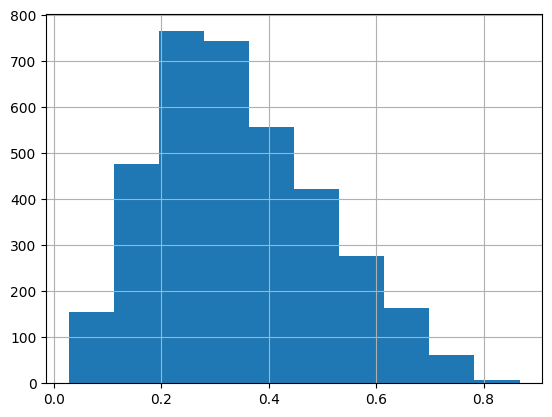

In [21]:
combined_df.loc[combined_df['positive_to_negative_sentiment_ratio']==100.0, 'positive_score'].hist()

In [22]:
X, y = combined_df.drop(['is_good_review'],axis=1), combined_df['is_good_review']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


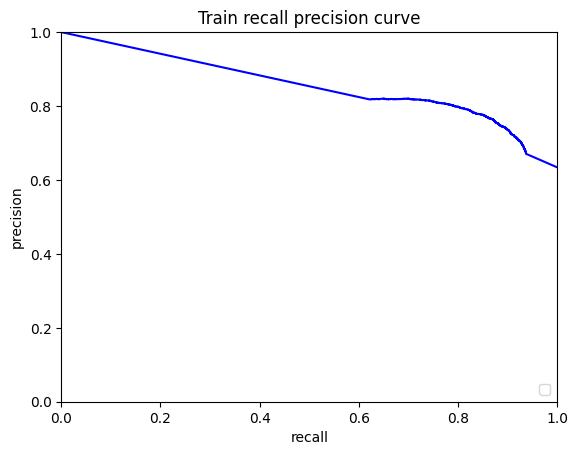

In [24]:
from sklearn.metrics import precision_recall_curve
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, X_train['positive_to_negative_sentiment_ratio'])

import matplotlib.pyplot as plt
plt.title('Train recall precision curve')
plt.plot( recall_train, precision_train, 'b',)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [25]:
opt_idx, recall_value = find_nearest(recall_train, 0.85)
opt_idx, recall_value, thresholds_train[opt_idx]

(900, 0.8500787401574803, 2.0920245398773005)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


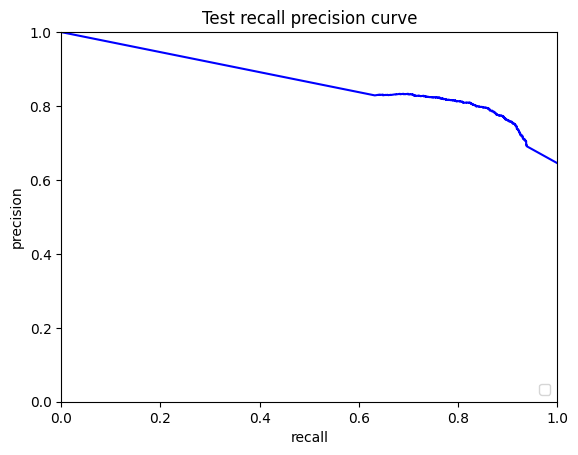

In [26]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, X_test['positive_to_negative_sentiment_ratio'])
# roc_auc = metrics.auc(precision, recall)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Test recall precision curve')
plt.plot( recall_test, precision_test, 'b',)# label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [27]:
idx_th, th_value = find_nearest(thresholds_test, 2.8469387755102042)
idx_th, th_value, recall_test[idx_th], precision_test[idx_th]

(517, 2.8428571428571425, 0.8229755178907722, 0.8092592592592592)

In [28]:
combined_df.loc[combined_df['positive_to_negative_sentiment_ratio'] > 2.8428571428571425]['is_good_review'].mean()

0.7990924092409241

In [29]:
optimal_ratio = 2.8469387755102042
positive_to_negative_sentiment_ratio_threshold = optimal_ratio

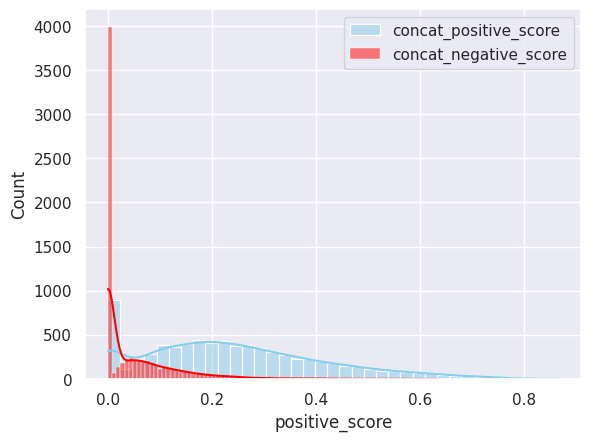

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
  
sns.set_theme(style="darkgrid")


sns.histplot(data=combined_df, x="positive_score", color="skyblue", label="concat_positive_score", kde=True)
sns.histplot(data=combined_df, x="negative_score", color="red", label="concat_negative_score", kde=True)

plt.legend() 
plt.show()

In [31]:
combined_df['positive_review_length'] = combined_df['positive_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df['negative_review_length'] = combined_df['negative_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df['positive_to_negative_length_ratio']= combined_df['positive_review_length']/combined_df['negative_review_length']
combined_df['review_length'] = combined_df['concat_review'].apply(lambda x: len(nltk.word_tokenize(str(x))))
combined_df.head()

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review,positive_review_length,negative_review_length,positive_to_negative_length_ratio,review_length
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000,100.000000,0,3,13,0.230769,17
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000,100.000000,1,2,50,0.040000,53
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242,0.000000,0,1,18,0.055556,20
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116,3.060345,1,15,13,1.153846,28
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000,100.000000,1,25,3,8.333333,28


In [32]:
combined_df.to_csv('combined_reviews_with_sentiment_scores.csv', index=False)

print("All files have been processed, sentiment scores calculated, and combined successfully.")

All files have been processed, sentiment scores calculated, and combined successfully.


<Axes: xlabel='positive_review_length', ylabel='negative_review_length'>

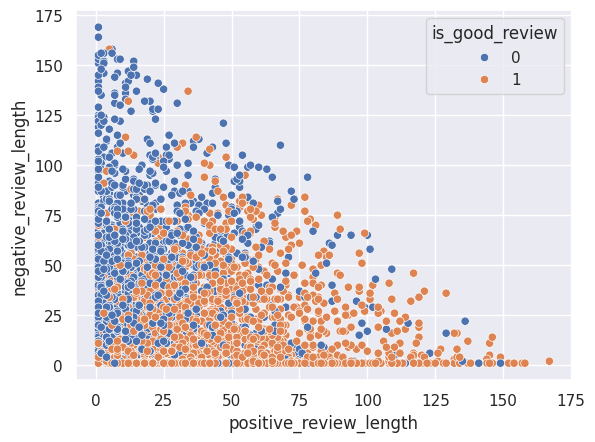

In [33]:
sns.scatterplot(data=combined_df, x="positive_review_length", y="negative_review_length", hue="is_good_review")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


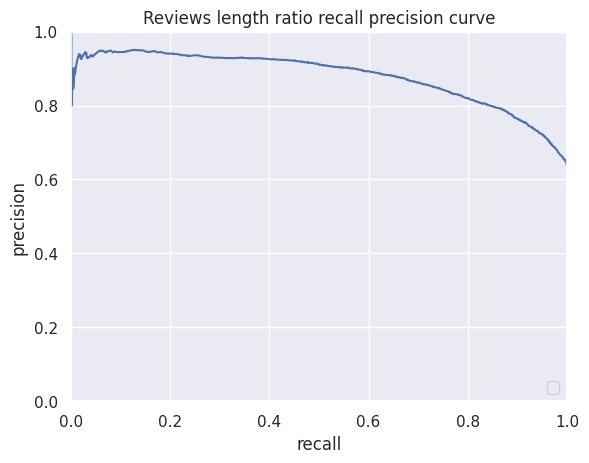

In [34]:
from sklearn.metrics import precision_recall_curve
precision_test, recall_test, thresholds_test = precision_recall_curve(combined_df['is_good_review'], combined_df['positive_to_negative_length_ratio'])

import matplotlib.pyplot as plt
plt.title('Reviews length ratio recall precision curve')
plt.plot( recall_test, precision_test, 'b',)# label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [35]:
opt_idx, recall_value = find_nearest(recall_test, 0.8)
opt_idx, recall_value, precision_test[opt_idx], thresholds_test[opt_idx]

(849, 0.8001258389261745, 0.8195488721804511, 0.8163265306122449)

In [36]:
optimal_length_ratio = 0.8163265306122449
good_to_bad_length_ratio_threshold = optimal_length_ratio

<Axes: xlabel='positive_review_length', ylabel='negative_review_length'>

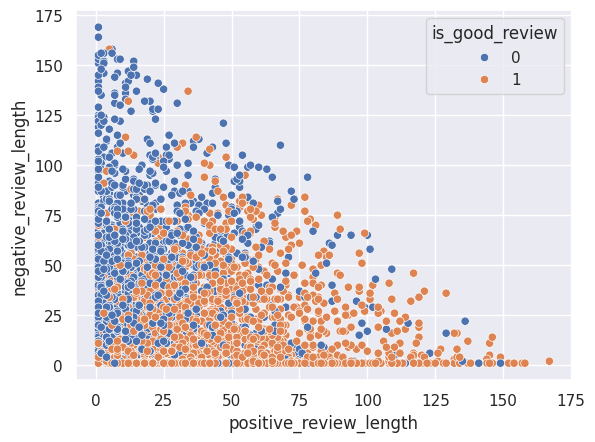

In [37]:
sns.scatterplot(data=combined_df, x="positive_review_length", y="negative_review_length", hue="is_good_review")

In [38]:
df = pd.read_csv('combined_reviews_with_sentiment_scores.csv')
df

,ID,positive_review,negative_review,rating,concat_review,positive_score,negative_score,positive_to_negative_sentiment_ratio,is_good_review,positive_review_length,negative_review_length,positive_to_negative_length_ratio,review_length
0,2411,Very nice room,Not too much choice for breakfast and the swim...,6.0,Very nice room. Not too much choice for breakf...,0.171,0.000,100.000000,0,3,13,0.230769,17
1,2272,Top facilities,Heating didn't work. It was warmer after I swi...,8.3,Top facilities. Heating didn't work. It was wa...,0.095,0.000,100.000000,1,2,50,0.040000,53
2,2561,NaN,Badly maintained hotel many switches not funct...,6.3,nan. Badly maintained hotel many switches not ...,0.000,0.242,0.000000,0,1,18,0.055556,20
3,1321,"Beautiful little balconette, gorgeous bathroom...","A few little stains, no coffee machine and emp...",8.0,"Beautiful little balconette, gorgeous bathroom...",0.355,0.116,3.060345,1,15,13,1.153846,28
4,1639,"Everything was good, location was good for sho...",Everything was comforting,10.0,"Everything was good, location was good for sho...",0.451,0.000,100.000000,1,25,3,8.333333,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7471,23647,"Location, room size, parking, staff",Noise from the highway with windows open.,9.0,"Location, room size, parking, staff. Noise fro...",0.000,0.000,0.000000,1,8,8,1.000000,17
7472,23652,The Locations is good.\nGood breakfast in COVI...,Very small room for a twin bed room.\nPoor ref...,6.0,The Locations is good.\nGood breakfast in COVI...,0.221,0.168,1.315476,0,12,23,0.521739,36
7473,24232,Parking space outside the hotel,"When I arrived to check in nobody was there, I...",4.6,Parking space outside the hotel. When I arrive...,0.000,0.126,0.000000,0,5,64,0.078125,70
7474,23728,The staff were polite and proffesional.,The breakfast could be more fresh and should c...,7.0,The staff were polite and proffesional.. The b...,0.166,0.143,1.160839,0,7,65,0.107692,72
